<a href="https://colab.research.google.com/github/DeveloperVivek9/Calorie-Tracker/blob/main/Deployment/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install detecto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
from detecto.utils import read_image
from glob import glob
from google.colab import drive
import io
import json
import os
import pandas as pd
import re
import shutil
import xml.etree.cElementTree as ET

In [ ]:
#Check if classes extracted is in classes_list.csv or not. If not, we have to remove them or add them to another csv file.
#Remove duplicate rows from csv where duplicate check for everything except image id, bndbox id since they get generated from previous rows

In [ ]:
#Function to move given file list from source directory to destination directory.
#file_list should only contain filenames not folder names.
#move=True if we want to move the files instead of copying.
def move_given_files(source_dir,destination_dir,file_list=None,move=False):
    """
    Moves files in file_list from source_dir to destination_dir.
    If no file list given, moves everything.
    move=False means copy else it will move the contents.
    """
    os.makedirs(destination_dir,exist_ok=True)
    if(file_list==None):
      file_list=next(os.walk(source_dir))[2]
    for file_name in file_list:
        if(move):
            #Since we are using shutil.move and shutil.copy for this with 
            #copy_function paramater NOT copytree, this is viable only for files not folders. 
            #shutil.move(source_dir+file_name, destination_dir+file_name,copy_function = shutil.copytree)
            #filesystem metadata may not be copied since shutil has a few issues. [metadata here means things like author, data modified]
            shutil.move(source_dir+file_name, destination_dir+file_name)
        else:
            shutil.copy(source_dir+file_name, destination_dir+file_name)

In [ ]:
#Design philosophy
#The csv file is like a database for bounding boxes instead of images. 
#Why bounding box instead of images? -> Bounding box are the simplest unit. 
#An image can have multiple bounding boxes, not the other way around. 
#This design also helps in removing bounding boxes that are done incorrectly instead of removing the images altogether.  
#Only annotated images are moved into the database/csv. [Database - csv used interchangeably since logic same]

In [ ]:
#DB -> id, image_path, image_name, width, height, class, xmin, ymin, xmax, ymax, Batch. 
#Here id will be for each bounding box since image can have multiple bounding boxes, multiple classes. Only unique identifier can be bounding box. 
#image_path so that we can easily change blob store or file systems
#image_name -> Name of image
#   Naming format should be specific. Every image name will correspond to (class name + id.ext). 
#   If multiple classes -> something to signify this
#   If augmentation is done, (classname + id + augmentation_type.extension)
#   We can filter out images where augmentation is not done. 
#   Depending on requirements, naming conventions should change. Name should be treated like id itself. 
#   Image id being there so that we can trace back in case some accidental change.
#width -> width of the image
#height -> height of the image
#class -> class of each bounding box. We can be sure that this corresponds to only one class. 
#We are specifying xmin, ymin, xmax, ymax so that we are aware of the format that is being used. 
#Batch in which it was trained in. 0 means it was trained before batch-wise training. 
#bndbox_df = pd.DataFrame(columns=['Bndbox ID','Image ID','Image Path','Image Name','Height','Width','Class','xmin','ymin','xmax','ymax','Batch'])
#bndbox_df.to_csv('Image Metadata.csv',encoding='utf-8', index=False)

In [ ]:
#csv file containing problematic image filenames [see function below]
#bad_files_df = pd.DataFrame(columns=['Image Name','Reason'])
#bad_files_df.to_csv('Bad Files.csv',encoding='utf-8', index=False)

In [ ]:
def class_in_list(s,string):
  """
  Returns string in s. This is to see whether class name exists in list(class_name). 
  This written as a function so that we can apply it on the dataframe.
  """
  return string in s

In [ ]:
#read csv xml_file
#write dataframe onto csv xml_file
def data_entry(class_dir,destination_dir,disparity_dir,image_extension_list=['.jpg', '.png', '.jpeg', '.JPG', '.webp', '.cms', '.jfif'],image_metadata_csv='Image Metadata.csv',bad_file_csv='Bad Files.csv',classes_list_csv="Classes_List.csv"):
  """
  Returns start and end index of added files in csv xml_file
  Moves proper data from class directory to destination directory while adding data onto csv xml_file.
  Gets data from xml files, reads every image.
  If data is proper and image is readable, writes onto a csv xml_file, both the files moved to destination directory.
  Else, xml xml_file along with image moved to disparity folder.
  Renames every image and xml xml_file with a name corresponding to id so that data isn't duplicated or replaced.  
  Requirements
    xml filename and image filename must be the same. 
    xml xml_file must follow pascal voc format only. 
  """
  os.makedirs(disparity_dir,exist_ok=True)
  os.makedirs(destination_dir,exist_ok=True)
  classes_df=pd.read_csv(classes_list_csv)
  #classes_df['Synonym']='Hart'
  #List of files that either have wrong bounding box coordinates or an unreadable image
  try:
    bndbox_df=pd.read_csv(image_metadata_csv)
  except FileNotFoundError:
    bndbox_df = pd.DataFrame(columns=['Bndbox ID','Image ID','Image Path','Image Name','Height','Width','Class','xmin','ymin','xmax','ymax','Batch'])
  
  #Get rows on Image metadata.csv which got added when function is called. If end_index=start_index, no entries added.
  try:
    start_index=bndbox_df.index[-1]+1
  except:
    start_index=0
  end_index=start_index

  try:
    bad_df=pd.read_csv(bad_file_csv)
  except FileNotFoundError:
    bad_df = pd.DataFrame(columns=['Image Name','XML Name','File name','Reason'])

  #List of files 
  file_list=next(os.walk(class_dir))[2]
  #Adds file having extension not in image extension list or xml to BAD_DICT
  for item in [x for x in file_list if os.path.splitext(x)[1] not in image_extension_list+[".xml"]]:
    shutil.move(class_dir+item, disparity_dir+str(len(bad_df.index))+" "+item)
    bad_df.loc[len(bad_df.index)]=[None,None,str(len(bad_df.index))+" "+item,'Bad Extension']   

  #List of files having xml extension
  xml_file_list=glob(class_dir+"*.xml")
  #To extract filename.extension from path+filename.extension [Here just xml extension since xml_file_list contains only xml files, see previous line]
  xml_file_list=[name.replace(class_dir[:-1]+"/","") for name in xml_file_list]            
  image_list=[]
  #Get list of files having extension equal to image extension in image extension list.
  for ext in image_extension_list:
    image_list.extend(glob(class_dir+'*'+ext))
  image_list=[name.replace(class_dir[:-1]+"/","") for name in image_list]
  #Get unique values in the list since .jpg == .JPG. It will occur twice in the xml_file list.
  image_list=[*set(image_list)]
  #print(xml_file_list,image_list)
  for xml_file in xml_file_list:
    #Image name of the current xml xml_file. [They have the same filename]
    image_name=[x for x in image_list if os.path.splitext(xml_file)[0]==os.path.splitext(x)[0]]

    #Image doesn't exist for xml xml_file
    if(len(image_name)<1):
      shutil.move(class_dir+xml_file, disparity_dir+str(len(bad_df.index))+" "+xml_file)
      bad_df.loc[len(bad_df.index)]=[None,str(len(bad_df.index))+" "+xml_file,None,'No Image Found']     
      print("No Image Found")
      continue

    image_name, = image_name
    print("At XML File : ",xml_file," Image File : ",image_name)
    #Trying to read image
    try:
      img=read_image(class_dir+image_name)
      #Unpacking into three values where we need the first two -> height, width of the image
      height,width=img.shape[0:2]
    #image unreadable or doesn't exist.
    except ValueError:
      shutil.move(class_dir+xml_file, disparity_dir+str(len(bad_df.index))+" "+xml_file)
      shutil.move(class_dir+image_name, disparity_dir+str(len(bad_df.index))+" "+image_name)
      bad_df.loc[len(bad_df.index)]=[str(len(bad_df.index))+" "+image_name,str(len(bad_df.index))+" "+xml_file,None,'Image Unreadable'] 
      print("Image Unreadable")  
      continue

    """-------------------------------------------------------------------------------------------------------------------------------"""
    #Get required details from xml xml_file
    try:
      tree=ET.parse(class_dir+xml_file)
    except ET.ParseError:
      shutil.move(class_dir+xml_file, disparity_dir+str(len(bad_df.index))+" "+xml_file)
      shutil.move(class_dir+image_name, disparity_dir+str(len(bad_df.index))+" "+image_name)
      bad_df.loc[len(bad_df.index)]=[str(len(bad_df.index))+" "+image_name,str(len(bad_df.index))+" "+xml_file,None,'XML Unreadable']   
      continue
    root = tree.getroot()
    bndbox=list()
    unique_file_name=list()
    flag1=False
    for box in root.findall('.//object'):
      #unique xml_file name + image_id -> is what we will rename the image
      #This naming convention is considering multiclass images where we can't keep track of every class combination using count. 
      #Therefore since image id is unique, the probability of duplicates is none.
      #Regex below is to remove special characters & numbers then capitalize first letters of every word.
      #We are removing numbers here since food names usually don't have numbers. If somehow that changes, make necessary changes here.
      class_name_in_bndbox=(re.sub(r"[^a-zA-Z]+", ' ',box.find('.//name').text)).title().strip()

      if(class_name_in_bndbox not in list(classes_df['Class Name'])):
        if(classes_df['Synonym'].apply(class_in_list,args=([class_name_in_bndbox])).any()):
          i=classes_df['Synonym'].apply(class_in_list,args=([class_name_in_bndbox])).index[0]
          class_name_in_bndbox=classes_df.iloc[i]['Class Name']
        else:
          flag1=True
          break

      unique_file_name.append(class_name_in_bndbox)
      bndbox.append(box.find('.//xmin').text)
      bndbox.append(box.find('.//ymin').text)
      bndbox.append(box.find('.//xmax').text)
      bndbox.append(box.find('.//ymax').text)

    #If class in xml file doesn't exist in classes_list.csv. The model would throw an error since it doesn't recognize class
    if(flag1):
      shutil.move(class_dir+xml_file, disparity_dir+str(len(bad_df.index))+" "+xml_file)
      shutil.move(class_dir+image_name, disparity_dir+str(len(bad_df.index))+" "+image_name)
      bad_df.loc[len(bad_df.index)]=[str(len(bad_df.index))+" "+image_name,str(len(bad_df.index))+" "+xml_file,None,'New Class or Incorrect Class']
      print('New Class or Incorrect Class')
      continue

    #Sets a flag if xmin > = xmax or ymin > = ymax
    count=0
    flag=False
    bndbox=[int(x) for x in [float(x) for x in bndbox]]
    for i in range(0,len(bndbox),4):
      if(bndbox[0+count*4]>=bndbox[2+count*4] or bndbox[1+count*4]>=bndbox[3+count*4]):
        flag=True
      count+=1

    if(len(bndbox)%4!=0 or flag or len(bndbox)==0):
      shutil.move(class_dir+xml_file, disparity_dir+str(len(bad_df.index))+" "+xml_file)
      shutil.move(class_dir+image_name, disparity_dir+str(len(bad_df.index))+" "+image_name)
      bad_df.loc[len(bad_df.index)]=[str(len(bad_df.index))+" "+image_name,str(len(bad_df.index))+" "+xml_file,None,'Wrong Bounding Box']
      print("Wrong Bounding Box")
      continue
    """-------------------------------------------------------------------------------------------------------------------------------"""
    #If the code block reaches till here it means the file is good to be added to our database.   
    try:
      unique_file_name="_".join(sorted(list(set(unique_file_name))))+" "+str(bndbox_df["Image ID"].iloc[-1]+1)
      image_id=bndbox_df["Image ID"].iloc[-1]+1
    except IndexError:
      unique_file_name="_".join(sorted(list(set(unique_file_name))))+" "+str(0)
      image_id=0
    

    for box in root.findall('.//object'):
      try:
        bndbox_id=bndbox_df["Bndbox ID"].iloc[-1]+1
      except IndexError: 
        bndbox_id=0
      image_path=destination_dir
      #New name of image will be unique_file_name + extension 
      #extension which is given by os.path.splitext(image_name)[1]
      new_image_name=unique_file_name+os.path.splitext(image_name)[1]
      #Remove special characters, numbers from class name. Capitalize first letter.
      class_name=(re.sub(r"[^a-zA-Z]+", ' ',box.find('.//name').text)).title().strip()
      xmin=int(box.find('.//xmin').text)
      ymin=int(box.find('.//ymin').text)
      xmax=int(box.find('.//xmax').text)
      ymax=int(box.find('.//ymax').text)
      batch=None
      #Add information to dataframe. 
      print(bndbox_id,image_id,image_path,new_image_name,height,width,class_name,xmin,ymin,xmax,ymax,batch, " Written")
      bndbox_df.loc[len(bndbox_df.index)]=[bndbox_id,image_id,image_path,new_image_name,height,width,class_name,xmin,ymin,xmax,ymax,batch]
      end_index+=1
    #We will rename using shutil.move itself
    shutil.move(class_dir+image_name, destination_dir+unique_file_name+os.path.splitext(image_name)[1])
    shutil.move(class_dir+xml_file, destination_dir+unique_file_name+os.path.splitext(xml_file)[1])

  bndbox_df.to_csv(image_metadata_csv,encoding='utf-8', index=False)
  bad_df.to_csv(bad_file_csv,encoding='utf-8', index=False)
  return start_index,end_index       

In [ ]:
"""
drive.mount('/content/drive')#, force_remount=True)
base_path='/content/drive/MyDrive/Experiment/Unannotated/'
disparity_dir='/content/drive/MyDrive/Experiment/Disparity/'
destination_dir='/content/drive/MyDrive/Experiment/Annotated/'
#os.remove('/content/drive/MyDrive/Experiment/Image Metadata.csv')
os.remove('/content/drive/MyDrive/Experiment/Bad Files.csv')
try:
  shutil.rmtree(base_path)
except FileNotFoundError:
  pass
try:
  shutil.rmtree(disparity_dir)
except FileNotFoundError:
  pass
try:
  shutil.rmtree(destination_dir)
except FileNotFoundError:
  pass
shutil.copytree('/content/drive/MyDrive/Experiment/Backup',base_path)
image_extension_list=['.jpg', '.png', '.jpeg', '.JPG', '.webp', '.cms', '.jfif']
for i in next(os.walk(base_path))[1]:
  data_entry(base_path+i,destination_dir,disparity_dir,image_extension_list,base_path+i+'/Image Metadata.csv',base_path+i+'/Bad Files.csv',base_path+i+"/Classes_List.csv")
data_entry(base_path,destination_dir,disparity_dir,image_extension_list,base_path+'Image Metadata.csv',base_path+'Bad Files.csv',base_path+"Classes_List.csv")
"""

In :  BAD_XML_4.jpg
In :  GOOD_XML_1.jpg
In :  BAD_XML_3.jpg
In :  BAD_XML_1.jpg
In :  BAD_XML_2.jpg
In :  CLASS_NAME_NOT_IN_CSV.jpg
In :  GOOD_XML_2.jpg
2 1 /content/drive/MyDrive/Experiment/Annotated/ Aaloo Chips 1.jpg 549 731 Aaloo Chips 378 57 613 189 None  Written
3 1 /content/drive/MyDrive/Experiment/Annotated/ Aaloo Chips 1.jpg 549 731 Aaloo Chips 200 100 613 189 None  Written


(2, 4)

In [ ]:
"""
for i in next(os.walk(base_path))[1]:
  data_entry(base_path+i+'/',destination_dir,disparity_dir,image_extension_list)
data_entry(base_path,destination_dir,disparity_dir,image_extension_list)
"""

# Database

https://stackoverflow.com/questions/72234035/python-code-to-connect-to-mysql-database-doesnt-work-on-google-colab
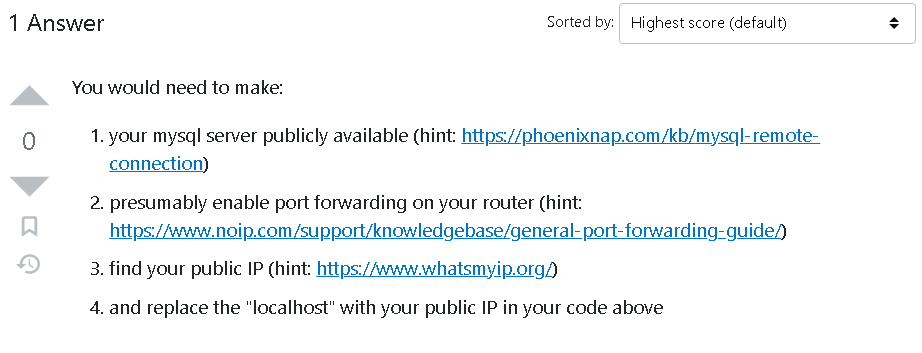

In [ ]:
"""
!pip install mysql.connector
"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.9 MB 6.8 MB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp38-cp38-linux_x86_64.whl size=247965 sha256=aa6905905611aacd39850bd9b278c9a59f3d7587bc41193f787566c8140c9210
  Stored in directory: /root/.cache/pip/wheels/57/e4/98/5feafb5c393dd2540e44b064a6f95832990d543e5b4f53ea8f
Successfully built mysql.connector


In [ ]:
"""
import mysql.connector as msql
from mysql.connector import Error
try:
    conn = msql.connect(host='localhost', user='root',  
                        password='root@123')#give ur username, password
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("CREATE DATABASE employee")
        print("Database is created")
except Error as e:
    print("Error while connecting to MySQL", e)
"""

In [ ]:
"""
#Create csv file then simply add it into the database
try:
    conn = mysql.connect(host='localhost', database='employee', user='root', password='root@123')
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        cursor.execute('DROP TABLE IF EXISTS employee_data;')
        print('Creating table....')
# in the below line please pass the create table statement which you want #to create
        cursor.execute("CREATE TABLE employee_data(first_name varchar(255),last_name varchar(255),company_name varchar(255),address varchar(255),city varchar(255),county varchar(255),state varchar(255),zip int,phone1 varchar(255),phone2 varchar(255),email varchar(255),web varchar(255))")
        print("Table is created....")
        #loop through the data frame
        for i,row in empdata.iterrows():
            #here %S means string values 
            sql = "INSERT INTO employee.employee_data VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"
            cursor.execute(sql, tuple(row))
            print("Record inserted")
            # the connection is not auto committed by default, so we must commit to save our changes
            conn.commit()
except Error as e:
    print("Error while connecting to MySQL", e)
"""

In [ ]:
"""
# Execute query
sql = "SELECT * FROM employee.employee_data"
cursor.execute(sql)
# Fetch all the records
result = cursor.fetchall()
for i in result:
    print(i)
"""